In [80]:
import numpy as np
import pandas as pd
import yfinance as yf
import json
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [81]:
# Load stock data
stock = "GOOG"
start = "2018-01-01"
end = "2024-12-31"
data = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [82]:
data.reset_index(inplace=True)

In [83]:
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2018-01-02,52.998974,53.095517,52.015135,52.169901,24752000
1,2018-01-03,53.868855,54.058455,52.909896,52.964637,28604000
2,2018-01-04,54.063931,54.420742,53.944596,54.143555,20092000
3,2018-01-05,54.851696,54.952222,54.342606,54.442137,25582000
4,2018-01-08,55.086086,55.301565,54.821341,54.851696,20952000
...,...,...,...,...,...,...
1755,2024-12-23,195.766968,196.266399,191.411929,193.809192,15235900
1756,2024-12-24,197.345184,197.445061,194.975874,195.946768,6809800
1757,2024-12-26,196.875717,197.934509,195.647106,196.516126,7907900


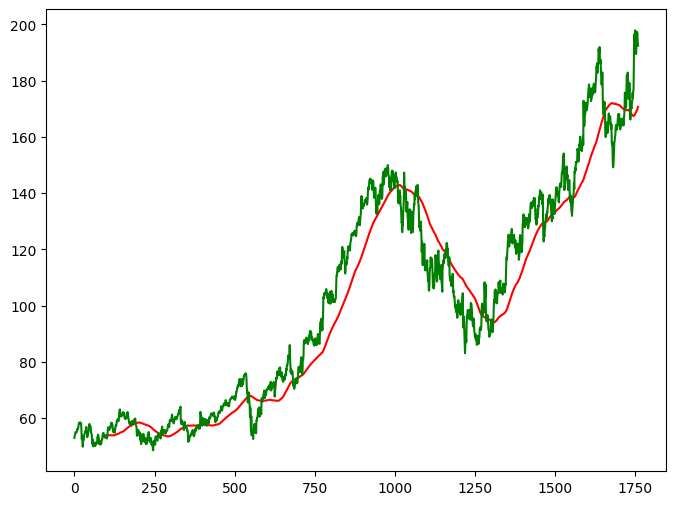

In [84]:
ma_100_days = data.Close.rolling(100).mean()
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [85]:
# Prepare data
data_train = data['Close'][0:int(len(data) * 0.80)]
data_test = data['Close'][int(len(data) * 0.80):]

scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(np.array(data_train).reshape(-1, 1))

In [86]:
# Create sequences
def create_sequences(data, time_step=100):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(data_train_scaled)

In [87]:
# Reshape for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [88]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0637
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0049 
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0045
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0037
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0037
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0034
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0035
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0033 
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0032
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0032 


In [90]:
# Prepare test data
past_100_days = data_train.tail(100)
data_test_scaled = scaler.transform(np.array(data_test).reshape(-1, 1))
x_test, y_test = create_sequences(data_test_scaled)

In [91]:
# Reshape test data
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [92]:
# Make predictions
predictions = model.predict(x_test)
scale_factor = 1 / scaler.scale_[0]
predictions = predictions * scale_factor
y_test = y_test * scale_factor

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 


In [93]:
# Calculate accuracy percentage
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
accuracy = 100 - mape  # Higher is better

# Save metrics to JSON
metrics = {"MSE": mse, "RMSE": rmse, "R2_Score": r2, "Accuracy_Percentage": accuracy}
with open("metrics.json", "w") as f:
    json.dump(metrics, f)

# Save the trained model
model.save("Stock_Predictions_Model.keras")

print(f"✅ Model trained & saved! Accuracy: {accuracy:.2f}%, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

✅ Model trained & saved! Accuracy: 84.62%, MSE: 117.1309, RMSE: 10.8227, R²: 0.8687
